In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd
from tqdm.notebook import tqdm
import h5py
import random
from sklearn.model_selection import GroupKFold
from sklearn.metrics import precision_score, recall_score, f1_score
import lightgbm as lgb
import warnings
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, ttest_rel, wilcoxon
from scipy.stats import zscore

In [2]:
mice = ['ym212','ym213','ym214','ym215','ym218','ym219','ym220','ym222','ym223','ym224','ym226','ym227']  # 12 in total
data_dir = r'/Users/david/Projects/Yuichi/MemoryAge_WinLen_5_Step_0.5/Data/DATA_win_len_5__step_0.5/'
sessions = ['RECENT','REMOTE']
feature_names = ['ACC_CA1_theta_corr', 'ACC_BLA_theta_corr', 'CA1_BLA_theta_corr',
                 'ACC_CA1_beta_corr', 'ACC_BLA_beta_corr', 'CA1_BLA_beta_corr',
                 'ACC_CA1_sGamma_corr', 'ACC_BLA_sGamma_corr', 'CA1_BLA_sGamma_corr',
                 'ACC_CA1_fGamma_corr', 'ACC_BLA_fGamma_corr', 'CA1_BLA_fGamma_corr',
                 'ACC_theta_power', 'CA1_theta_power', 'BLA_theta_power',
                 'ACC_beta_power', 'CA1_beta_power', 'BLA_beta_power',
                 'ACC_sGamma_power', 'CA1_sGamma_power', 'BLA_sGamma_power',
                 'ACC_fGamma_power', 'CA1_fGamma_power', 'BLA_fGamma_power']

EXCLUSIVE_MODE = False
TARGET_MOUSE = 'ym227'

## 1. Load and Construct Feature Dataset

In [3]:
Dataset = []

for mouse in tqdm(mice):
    for session in sessions:
        features_dir_tmp = data_dir + 'ALL_feature_vectors_' + session + '_' + mouse + '.mat'
        feature_vectors_tmp = h5py.File(features_dir_tmp, 'r')
        feature_vectors_tmp = feature_vectors_tmp.get('ALL_feature_vectors')[()].transpose()  # type = numpy array, shape = (sample num, 24)
        
        feature_vectors_DF_tmp = pd.DataFrame(feature_vectors_tmp, columns=feature_names)
        feature_vectors_DF_tmp['mouse_name'] = mouse

        if session == 'RECENT':
            feature_vectors_DF_tmp['target'] = 0
        else:
            feature_vectors_DF_tmp['target'] = 1

        Dataset.append(feature_vectors_DF_tmp)

Dataset = pd.concat(Dataset, axis=0).reset_index(drop=True)

A Jupyter Widget

#### Groupby the mice first, then Z-score each feature SEPARATELY.

In [4]:
Dataset_Zscore = Dataset.groupby(['mouse_name']).transform(func=zscore, axis=0)
# axis=0: If 0 or ‘index’: apply function to each column

Dataset_Zscore['target'] = Dataset['target']
Dataset_Zscore['mouse_name'] = Dataset['mouse_name']

Dataset = Dataset_Zscore.copy()
del Dataset_Zscore

Feature: ACC_CA1_theta_corr, p-value: 0.02685546875
Feature: ACC_BLA_theta_corr, p-value: 0.26611328125
Feature: CA1_BLA_theta_corr, p-value: 0.67724609375
Feature: ACC_CA1_beta_corr, p-value: 0.10986328125
Feature: ACC_BLA_beta_corr, p-value: 0.20361328125
Feature: CA1_BLA_beta_corr, p-value: 0.10986328125
Feature: ACC_CA1_sGamma_corr, p-value: 0.38037109375
Feature: ACC_BLA_sGamma_corr, p-value: 0.4697265625
Feature: CA1_BLA_sGamma_corr, p-value: 0.26611328125
Feature: ACC_CA1_fGamma_corr, p-value: 0.01220703125
Feature: ACC_BLA_fGamma_corr, p-value: 0.5693359375
Feature: CA1_BLA_fGamma_corr, p-value: 1.0
Feature: ACC_theta_power, p-value: 0.38037109375
Feature: CA1_theta_power, p-value: 0.0009765625
Feature: BLA_theta_power, p-value: 0.90966796875
Feature: ACC_beta_power, p-value: 0.00927734375
Feature: CA1_beta_power, p-value: 0.06396484375
Feature: BLA_beta_power, p-value: 0.00927734375
Feature: ACC_sGamma_power, p-value: 0.10986328125
Feature: CA1_sGamma_power, p-value: 0.0771484

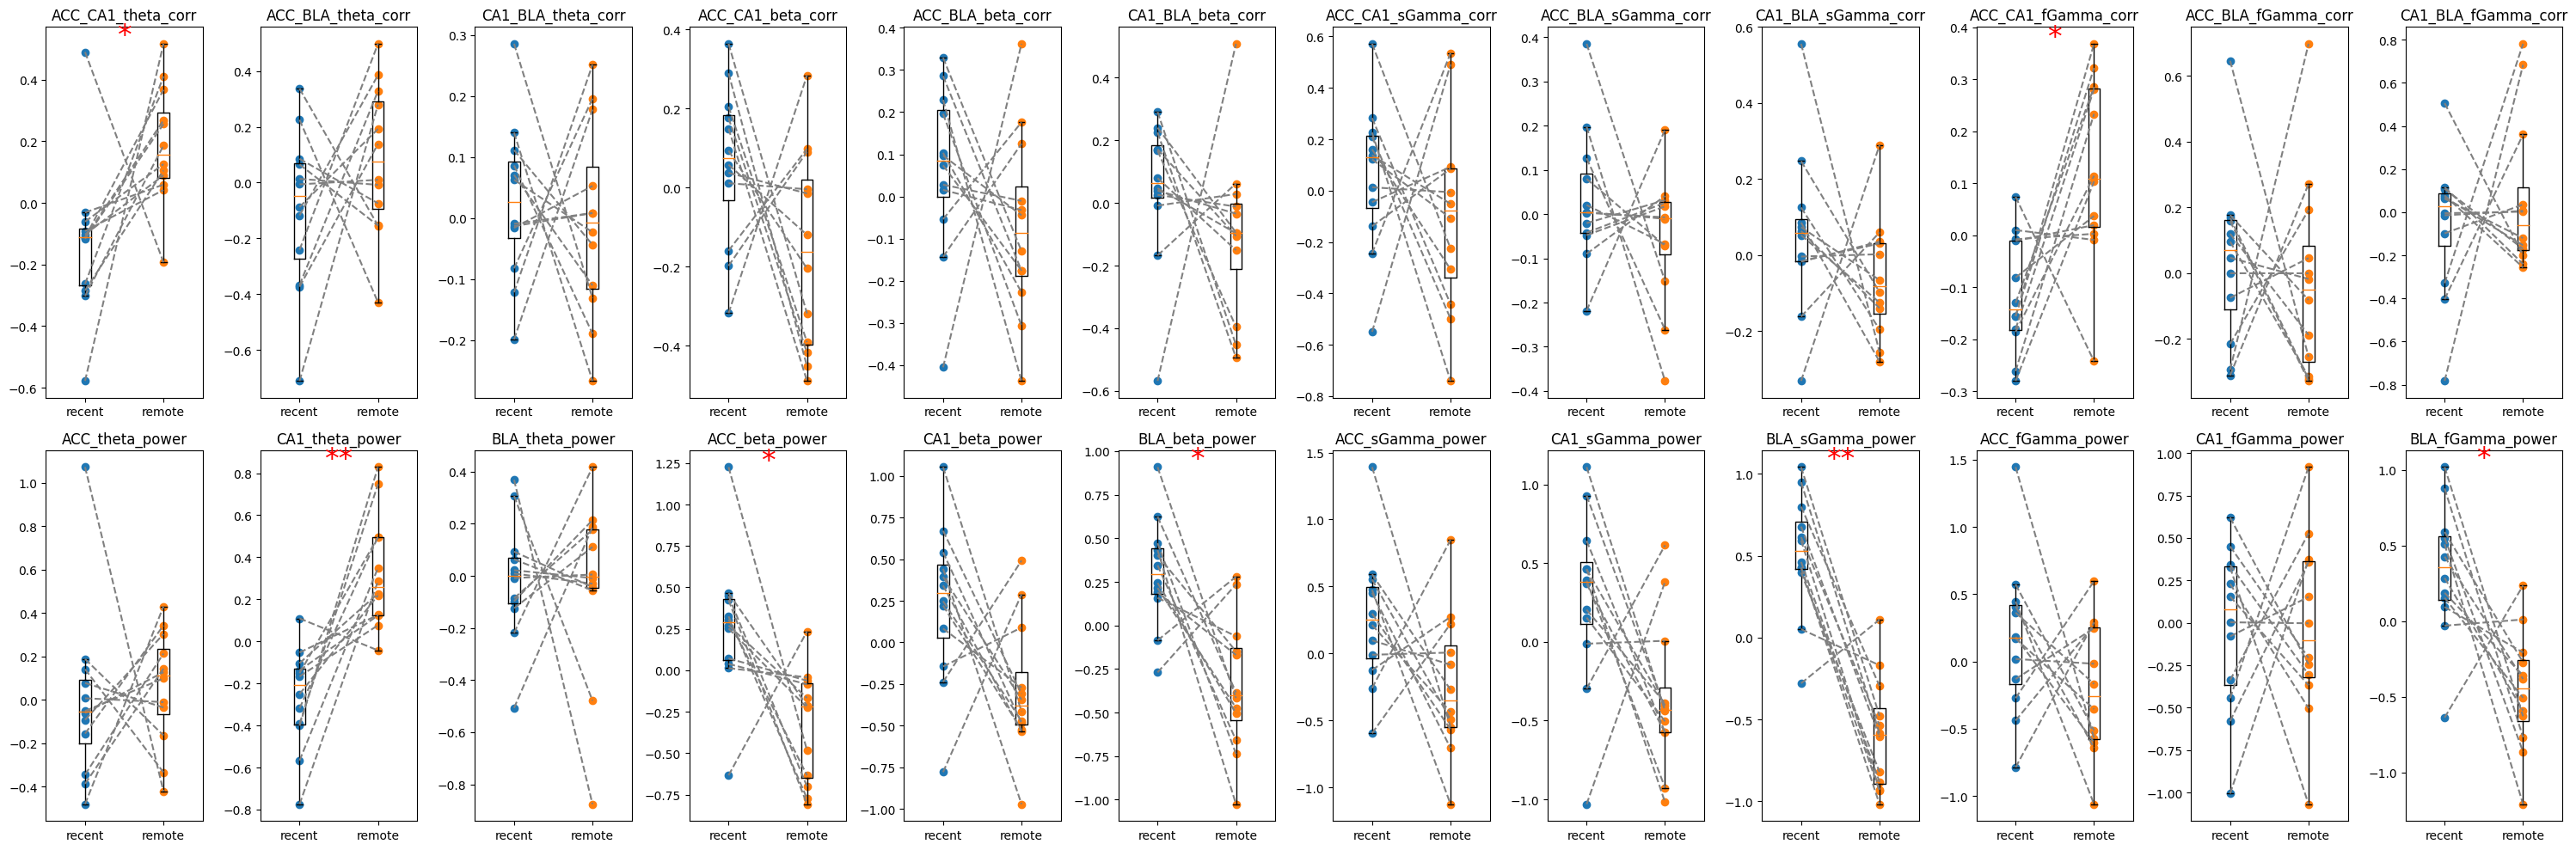

In [5]:
if EXCLUSIVE_MODE:

    # get the target mouse dataframe   
    Dataset_check = Dataset.loc[Dataset['mouse_name']==TARGET_MOUSE, :].reset_index(drop=True)
    # for each feature, calculate the mean of recent, the mean of remote
    Dataset_check = Dataset_check.groupby(['mouse_name','target']).mean().reset_index()

    # get all the other mice dataframe
    Dataset_rest =  Dataset.loc[Dataset['mouse_name']!=TARGET_MOUSE, :].reset_index(drop=True)
    # for each feature (and each mouse), calculate the mean of recent, the mean of remote
    Dataset_rest = Dataset_rest.groupby(['mouse_name','target']).mean().reset_index()

    fig, axs = plt.subplots(nrows=2, ncols=12, figsize=(30,10))  # first row is amp_env_corr, second row is power

    for feature_idx, feature in enumerate(feature_names):

        # for each mouse, we have a mean for the feature when target=0 and =1
        # we get the means of the feature when target=0, from all the mice
        recent_feature = Dataset_rest.loc[Dataset_rest['target']==0, feature].values
        # we get the means of the feature when target=1, from all the mice
        remote_feature = Dataset_rest.loc[Dataset_rest['target']==1, feature].values

        # significance, 
        stat, p = wilcoxon(recent_feature, remote_feature)
        print(f'Feature: {feature}, p-value: {p}')

        # ----- ploting -----
        row = int(np.floor(feature_idx/12))
        col = int(feature_idx%12)
        positions = [1,2]
        # plot all the means of the feature from different mice in boxplot, recent vs remote
        axs[row, col].boxplot([recent_feature, remote_feature], positions=positions, showfliers=False)

        # plot sactter dots, and connect paired dots
        axs[row, col].scatter([1]*len(recent_feature), recent_feature)
        axs[row, col].scatter([2]*len(remote_feature), remote_feature)
        for i in range(len(recent_feature)):
            axs[row, col].plot([1,2],[recent_feature[i], remote_feature[i]], linestyle='--', color='gray')

        # plot the mean of the feature of the TARGET MOUSE.
        # because I want to whether the mean of the feature for the TARGET MOUSE is differe from the general distritbution.
        axs[row, col].plot(1, Dataset_check.loc[Dataset_check['target']==0, feature].values[0], 'k', marker='s')
        axs[row, col].plot(2, Dataset_check.loc[Dataset_check['target']==1, feature].values[0], 'k', marker='s')

        axs[row, col].set_xticklabels(['recent', 'remote'])
        axs[row, col].set_title(feature)
        # draw a star
        if 0.005 < p <0.05:
            axs[row, col].text(1.5, axs[row, col].get_ylim()[1]*0.95, '*', fontsize=24, color='r', ha='center', va='center')
        elif 0.0005 < p <0.005:
            axs[row, col].text(1.5, axs[row, col].get_ylim()[1]*0.95, '**', fontsize=24, color='r', ha='center', va='center')
        elif 0.00005 < p <0.0005:
            axs[row, col].text(1.5, axs[row, col].get_ylim()[1]*0.95, '***', fontsize=24, color='r', ha='center', va='center')
        else:
            pass
        fig.tight_layout()

    plt.show()

else:

    Dataset_feature_mean = Dataset.groupby(['mouse_name','target']).mean().reset_index()

    fig, axs = plt.subplots(nrows=2, ncols=12, figsize=(30,10))

    for feature_idx, feature in enumerate(feature_names):

        recent_feature = Dataset_feature_mean.loc[Dataset_feature_mean['target']==0, feature].values
        remote_feature = Dataset_feature_mean.loc[Dataset_feature_mean['target']==1, feature].values

        # significance, paired t test
        stat, p = wilcoxon(recent_feature, remote_feature)
        print(f'Feature: {feature}, p-value: {p}')

        # ----- ploting -----
        row = int(np.floor(feature_idx/12))
        col = int(feature_idx%12)
        positions = [1,2]
        # plot all the means of the feature from different mice in boxplot, recent vs remote
        axs[row, col].boxplot([recent_feature, remote_feature], positions=positions, showfliers=False)

        # plot sactter dots, and connect paired dots
        axs[row, col].scatter([1]*len(recent_feature), recent_feature)
        axs[row, col].scatter([2]*len(remote_feature), remote_feature)
        for i in range(len(recent_feature)):
            axs[row, col].plot([1,2],[recent_feature[i], remote_feature[i]], linestyle='--', color='gray')

        # setting
        axs[row, col].set_xticklabels(['recent', 'remote'])
        axs[row, col].set_title(feature)
        
        # draw a star
        if 0.005 < p <0.05:
            axs[row, col].text(1.5, axs[row, col].get_ylim()[1]*0.95, '*', fontsize=24, color='r', ha='center', va='center')
        elif 0.0005 < p <0.005:
            axs[row, col].text(1.5, axs[row, col].get_ylim()[1]*0.95, '**', fontsize=24, color='r', ha='center', va='center')
        elif 0.00005 < p <0.0005:
            axs[row, col].text(1.5, axs[row, col].get_ylim()[1]*0.95, '***', fontsize=24, color='r', ha='center', va='center')
        else:
            pass
        fig.tight_layout()

    plt.show()

#### 2. For each feature from each mouse, check whether there is a significant difference between recent and remote

In [6]:
p_value_df = pd.DataFrame(columns=['mouse_name']+feature_names)
p_value_df['mouse_name'] = mice
flag_df = pd.DataFrame(columns=['mouse_name']+feature_names)
flag_df['mouse_name'] = mice

for mouse in mice:
    for feature in feature_names:

        recent_feature = Dataset.loc[(Dataset['mouse_name']==mouse) & (Dataset['target']==0), feature]
        remote_feature = Dataset.loc[(Dataset['mouse_name']==mouse) & (Dataset['target']==1), feature]

        # 1.
        stat, p = mannwhitneyu(recent_feature, remote_feature)
        p_value_df.loc[p_value_df['mouse_name']==mouse, feature] = p

        # 2.
        recent_feature_median = np.median(recent_feature)
        remote_feature_median = np.median(remote_feature)
        if recent_feature_median > remote_feature_median:
            flag = 1
        else:
            flag = 0
        flag_df.loc[flag_df['mouse_name']==mouse, feature] = flag

In [7]:
feature_sig_stat_df = pd.DataFrame(columns=['FEATURE','num_of_mice_with_sig_diff', 'num_of_mice_recent_bigger_remote'])
feature_sig_stat_df['FEATURE'] = feature_names
for feature_idx, feature in enumerate(feature_names):
    
    mice_with_sig = np.sum(p_value_df[feature] < 0.05)
    mice_with_recent_bigger = np.sum(flag_df.loc[p_value_df[feature] < 0.05, feature])

    feature_sig_stat_df.loc[feature_sig_stat_df['FEATURE']==feature, 'num_of_mice_with_sig_diff'] = mice_with_sig
    feature_sig_stat_df.loc[feature_sig_stat_df['FEATURE']==feature, 'num_of_mice_recent_bigger_remote'] = mice_with_recent_bigger

feature_sig_stat_df

,FEATURE,num_of_mice_with_sig_diff,num_of_mice_recent_bigger_remote
0,ACC_CA1_theta_corr,10,1
1,ACC_BLA_theta_corr,10,4
2,CA1_BLA_theta_corr,8,5
3,ACC_CA1_beta_corr,9,7
4,ACC_BLA_beta_corr,8,6
5,CA1_BLA_beta_corr,8,6
6,ACC_CA1_sGamma_corr,11,7
7,ACC_BLA_sGamma_corr,4,3
8,CA1_BLA_sGamma_corr,8,6
9,ACC_CA1_fGamma_corr,8,1


In [8]:
p_value_df

,mouse_name,ACC_CA1_theta_corr,ACC_BLA_theta_corr,CA1_BLA_theta_corr,ACC_CA1_beta_corr,ACC_BLA_beta_corr,CA1_BLA_beta_corr,ACC_CA1_sGamma_corr,ACC_BLA_sGamma_corr,CA1_BLA_sGamma_corr,...,BLA_theta_power,ACC_beta_power,CA1_beta_power,BLA_beta_power,ACC_sGamma_power,CA1_sGamma_power,BLA_sGamma_power,ACC_fGamma_power,CA1_fGamma_power,BLA_fGamma_power
0,ym212,0.317388,0.0,0.000094,0.047684,0.071166,0.313823,0.309567,0.122693,0.0,...,0.121071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ym213,0.000078,0.000739,0.011841,0.003475,0.002151,0.0,0.0,0.066852,0.04798,...,0.007158,0.166106,0.0,0.0,0.000189,0.0,0.0,0.0,0.0,0.011617
2,ym214,0.026337,0.0,0.000024,0.082798,0.3334,0.058668,0.046964,0.000055,0.474225,...,0.001364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ym215,0.000005,0.0,0.052068,0.386317,0.247597,0.014882,0.015725,0.365338,0.015275,...,0.0,0.0,0.0,0.000003,0.0,0.0,0.0,0.0,0.0,0.0
4,ym218,0.358239,0.0,0.000342,0.0,0.0,0.039832,0.0,0.0,0.175638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00099,0.024603,0.0
5,ym219,0.0,0.220032,0.00193,0.0,0.0,0.0,0.0,0.213642,0.000001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,ym220,0.0,0.0,0.026128,0.454774,0.000001,0.048253,0.0,0.000001,0.003852,...,0.256549,0.0,0.0,0.016893,0.0,0.0,0.00037,0.0,0.0,0.21785
7,ym222,0.000043,0.006024,0.000135,0.0,0.005925,0.0,0.0,0.248261,0.02226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,ym223,0.000004,0.000006,0.223371,0.0,0.054237,0.447644,0.0,0.115016,0.005584,...,0.117478,0.177351,0.000814,0.021617,0.0,0.0,0.016053,0.0,0.0,0.0
9,ym224,0.0,0.402497,0.492456,0.000462,0.000001,0.000048,0.000851,0.417198,0.429562,...,0.434473,0.000001,0.005919,0.0,0.461644,0.483462,0.0,0.0,0.0,0.0


In [9]:
flag_df

,mouse_name,ACC_CA1_theta_corr,ACC_BLA_theta_corr,CA1_BLA_theta_corr,ACC_CA1_beta_corr,ACC_BLA_beta_corr,CA1_BLA_beta_corr,ACC_CA1_sGamma_corr,ACC_BLA_sGamma_corr,CA1_BLA_sGamma_corr,...,BLA_theta_power,ACC_beta_power,CA1_beta_power,BLA_beta_power,ACC_sGamma_power,CA1_sGamma_power,BLA_sGamma_power,ACC_fGamma_power,CA1_fGamma_power,BLA_fGamma_power
0,ym212,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
1,ym213,0,0,1,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,1,1
2,ym214,0,0,0,1,0,1,0,1,0,...,0,1,0,1,1,0,1,1,0,1
3,ym215,0,0,1,0,1,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,ym218,0,1,1,1,1,1,1,1,0,...,0,1,1,1,1,1,1,0,0,1
5,ym219,0,0,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,0,1
6,ym220,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,0
7,ym222,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,ym223,0,0,0,1,0,0,1,1,1,...,1,1,1,1,0,1,1,1,1,1
9,ym224,0,0,1,0,1,1,0,1,1,...,1,1,0,1,1,0,1,0,0,1
